<a href="https://colab.research.google.com/github/zxs1652/zcq/blob/master/%E8%8B%B1%E6%96%87%E6%89%8B%E5%86%99%E5%AD%97%E7%AC%A6%E8%AF%86%E5%88%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Mar 10 02:20:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [36]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [38]:
!unzip /content/gdrive/MyDrive/colab/class/Img.zip -d /content/gdrive/MyDrive/colab/class/img

Archive:  /content/gdrive/MyDrive/colab/class/Img.zip
   creating: /content/gdrive/MyDrive/colab/class/img/Img/
   creating: /content/gdrive/MyDrive/colab/class/img/Img/0/
  inflating: /content/gdrive/MyDrive/colab/class/img/Img/0/img001-001.png  
  inflating: /content/gdrive/MyDrive/colab/class/img/Img/0/img001-002.png  
  inflating: /content/gdrive/MyDrive/colab/class/img/Img/0/img001-003.png  
  inflating: /content/gdrive/MyDrive/colab/class/img/Img/0/img001-004.png  
  inflating: /content/gdrive/MyDrive/colab/class/img/Img/0/img001-005.png  
  inflating: /content/gdrive/MyDrive/colab/class/img/Img/0/img001-006.png  
  inflating: /content/gdrive/MyDrive/colab/class/img/Img/0/img001-007.png  
  inflating: /content/gdrive/MyDrive/colab/class/img/Img/0/img001-008.png  
  inflating: /content/gdrive/MyDrive/colab/class/img/Img/0/img001-009.png  
  inflating: /content/gdrive/MyDrive/colab/class/img/Img/0/img001-010.png  
  inflating: /content/gdrive/MyDrive/colab/class/img/Img/0/img001-01

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
!pip install tensorflow-gpu==2.0.0-beta0
!pip install tensorflow_hub
import pandas as pd
# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [124]:
data_root='/content/gdrive/MyDrive/colab/class/img/Img'

In [125]:
import tensorflow as tf
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
#datagen_kwargs_train = dict(rescale=1./255)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

/content/gdrive/MyDrive/colab/class/img/Img
Found 682 images belonging to 36 classes.
Found 2728 images belonging to 36 classes.


In [126]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key for key, value in dataset_labels])
print(dataset_labels)


Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 36)
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h'
 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [42]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

In [43]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 36)                46116     
Total params: 2,304,100
Trainable params: 46,116
Non-trainable params: 2,257,984
_________________________________________________________________


In [44]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [45]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit_generator(
    train_generator, 
    epochs=5,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if len(self._training_endpoints) > 1:


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
86/86 [==============================] - ETA: 0s - loss: 3.4506 - acc: 0.1252WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f9ed377b290> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
86/86 [==============================] - 78s 504ms/step - loss: 3.4425 - acc: 0.1267 - val_loss: 1.4565 - val_acc: 0.6378
Epoch 2/5
86/86 [==============================] - 42s 491ms/step - loss: 1.5502 - acc: 0.5382 - val_loss: 0.9821 - val_acc: 0.7478
Epoch 3/5
86/86 [==============================] - 42s 486ms/step - loss: 1.0923 - acc: 0.6839 - val_loss: 0.8339 - val_acc: 0.7566
Epoch 4/5
86/86 [==============================] - 43s 495ms/step - loss: 0.8923 - acc: 0.7357 - val_loss: 0.7071 - val_acc: 0.7830
Epoch 5/5
86/86 [==============================] - 42s 483ms/step - loss: 0.7293 - acc: 0.7877 - val_loss: 0.6918 - val_acc: 0.8006


In [46]:
hist1 = model.fit_generator(
    train_generator, 
    epochs=20,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if len(self._training_endpoints) > 1:


Epoch 1/20
86/86 [==============================] - 42s 487ms/step - loss: 0.6514 - acc: 0.8112 - val_loss: 0.6284 - val_acc: 0.8211
Epoch 2/20
86/86 [==============================] - 42s 485ms/step - loss: 0.5940 - acc: 0.8200 - val_loss: 0.5918 - val_acc: 0.8182
Epoch 3/20
86/86 [==============================] - 41s 482ms/step - loss: 0.5482 - acc: 0.8427 - val_loss: 0.5442 - val_acc: 0.8446
Epoch 4/20
86/86 [==============================] - 42s 483ms/step - loss: 0.5004 - acc: 0.8460 - val_loss: 0.5292 - val_acc: 0.8607
Epoch 5/20
86/86 [==============================] - 41s 478ms/step - loss: 0.4522 - acc: 0.8710 - val_loss: 0.5258 - val_acc: 0.8592
Epoch 6/20
86/86 [==============================] - 42s 483ms/step - loss: 0.4310 - acc: 0.8717 - val_loss: 0.5237 - val_acc: 0.8578
Epoch 7/20
86/86 [==============================] - 41s 477ms/step - loss: 0.4019 - acc: 0.8831 - val_loss: 0.5190 - val_acc: 0.8475
Epoch 8/20
86/86 [==============================] - 41s 482ms/step - 

In [47]:
hist2 = model.fit_generator(
    train_generator, 
    epochs=20,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if len(self._training_endpoints) > 1:


Epoch 1/20
86/86 [==============================] - 43s 503ms/step - loss: 0.2144 - acc: 0.9366 - val_loss: 0.4575 - val_acc: 0.8680
Epoch 2/20
86/86 [==============================] - 43s 497ms/step - loss: 0.2069 - acc: 0.9402 - val_loss: 0.4672 - val_acc: 0.8651
Epoch 3/20
86/86 [==============================] - 42s 494ms/step - loss: 0.2059 - acc: 0.9435 - val_loss: 0.4483 - val_acc: 0.8768
Epoch 4/20
86/86 [==============================] - 42s 492ms/step - loss: 0.2003 - acc: 0.9432 - val_loss: 0.4465 - val_acc: 0.8768
Epoch 5/20
86/86 [==============================] - 42s 484ms/step - loss: 0.1903 - acc: 0.9410 - val_loss: 0.4423 - val_acc: 0.8783
Epoch 6/20
86/86 [==============================] - 42s 485ms/step - loss: 0.1837 - acc: 0.9439 - val_loss: 0.4287 - val_acc: 0.8680
Epoch 7/20
86/86 [==============================] - 42s 493ms/step - loss: 0.1913 - acc: 0.9468 - val_loss: 0.4720 - val_acc: 0.8592
Epoch 8/20
86/86 [==============================] - 43s 498ms/step - 

In [48]:
hist3 = model.fit_generator(
    train_generator, 
    epochs=20,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if len(self._training_endpoints) > 1:


Epoch 1/20
86/86 [==============================] - 43s 498ms/step - loss: 0.1300 - acc: 0.9633 - val_loss: 0.4539 - val_acc: 0.8754
Epoch 2/20
86/86 [==============================] - 42s 493ms/step - loss: 0.1280 - acc: 0.9644 - val_loss: 0.4546 - val_acc: 0.8739
Epoch 3/20
86/86 [==============================] - 43s 497ms/step - loss: 0.1361 - acc: 0.9619 - val_loss: 0.4657 - val_acc: 0.8666
Epoch 4/20
86/86 [==============================] - 43s 496ms/step - loss: 0.1324 - acc: 0.9593 - val_loss: 0.4704 - val_acc: 0.8680
Epoch 5/20
86/86 [==============================] - 42s 494ms/step - loss: 0.1263 - acc: 0.9655 - val_loss: 0.4715 - val_acc: 0.8724
Epoch 6/20
86/86 [==============================] - 42s 494ms/step - loss: 0.1394 - acc: 0.9520 - val_loss: 0.4324 - val_acc: 0.8812
Epoch 7/20
86/86 [==============================] - 42s 494ms/step - loss: 0.1272 - acc: 0.9641 - val_loss: 0.4576 - val_acc: 0.8783
Epoch 8/20
86/86 [==============================] - 43s 495ms/step - 

In [49]:
hist4 = model.fit_generator(
    train_generator, 
    epochs=20,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if len(self._training_endpoints) > 1:


Epoch 1/20
86/86 [==============================] - 43s 500ms/step - loss: 0.1081 - acc: 0.9637 - val_loss: 0.4617 - val_acc: 0.8768
Epoch 2/20
86/86 [==============================] - 42s 494ms/step - loss: 0.1038 - acc: 0.9740 - val_loss: 0.4803 - val_acc: 0.8666
Epoch 3/20
86/86 [==============================] - 42s 494ms/step - loss: 0.1008 - acc: 0.9707 - val_loss: 0.4808 - val_acc: 0.8651
Epoch 4/20
86/86 [==============================] - 42s 493ms/step - loss: 0.1017 - acc: 0.9725 - val_loss: 0.4657 - val_acc: 0.8680
Epoch 5/20
86/86 [==============================] - 43s 495ms/step - loss: 0.0999 - acc: 0.9677 - val_loss: 0.4419 - val_acc: 0.8783
Epoch 6/20
86/86 [==============================] - 42s 494ms/step - loss: 0.1013 - acc: 0.9659 - val_loss: 0.4333 - val_acc: 0.8915
Epoch 7/20
86/86 [==============================] - 43s 497ms/step - loss: 0.0951 - acc: 0.9721 - val_loss: 0.4785 - val_acc: 0.8798
Epoch 8/20
86/86 [==============================] - 43s 497ms/step - 

In [50]:
import yaml
import json
%cd /content/gdrive/MyDrive/colab/saved_models
# 保存模型结构到yaml文件
yaml_string = model.to_yaml()
open('hand_model_architecture.yaml', 'w').write(yaml_string)
# 保存模型参数到h5文件
model.save_weights('hand_model_weights.h5')

/content/gdrive/MyDrive/colab/saved_models


In [51]:
accuracy0 = hist.history['acc']
val_accuracy0 = hist.history['val_acc']
loss0 = hist.history['loss']
val_loss0 = hist.history['val_loss']

In [52]:
accuracy1 = hist1.history['acc']
val_accuracy1 = hist1.history['val_acc']
loss1 = hist1.history['loss']
val_loss1 = hist1.history['val_loss']

In [53]:
accuracy2 = hist2.history['acc']
val_accuracy2 = hist2.history['val_acc']
loss2 = hist2.history['loss']
val_loss2 = hist2.history['val_loss']

In [54]:
accuracy3 = hist3.history['acc']
val_accuracy3 = hist3.history['val_acc']
loss3 = hist3.history['loss']
val_loss3 = hist3.history['val_loss']

In [55]:
accuracy4 = hist4.history['acc']
val_accuracy4 = hist4.history['val_acc']
loss4 = hist4.history['loss']
val_loss4 = hist4.history['val_loss']

In [56]:
accuracy=accuracy0+accuracy1+accuracy2+accuracy3+accuracy4
val_accuracy=val_accuracy0+val_accuracy1+val_accuracy2+val_accuracy3+val_accuracy4
loss=loss0+loss1+loss2+loss3+loss4
val_loss=val_loss0+val_loss1+val_loss2+val_loss3+val_loss4

Text(0.5, 1.0, 'trainset accuracy')

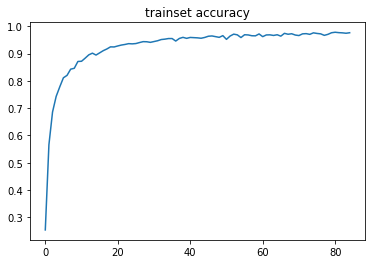

In [57]:
plt.plot(accuracy)
plt.title('trainset accuracy')

Text(0.5, 1.0, 'validset accuracy')

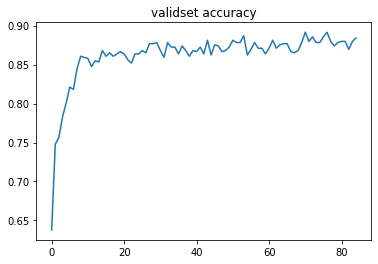

In [58]:
plt.plot(val_accuracy)
plt.title('validset accuracy')

Text(0.5, 1.0, 'trainset loss')

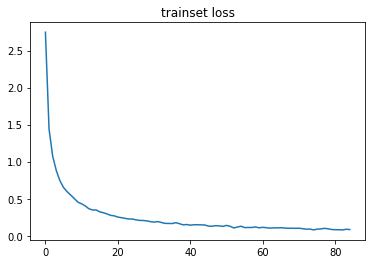

In [59]:
plt.plot(loss)
plt.title('trainset loss')

Text(0.5, 1.0, 'validset loss')

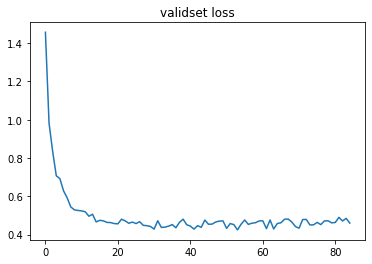

In [60]:
plt.plot(val_loss)
plt.title('validset loss')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


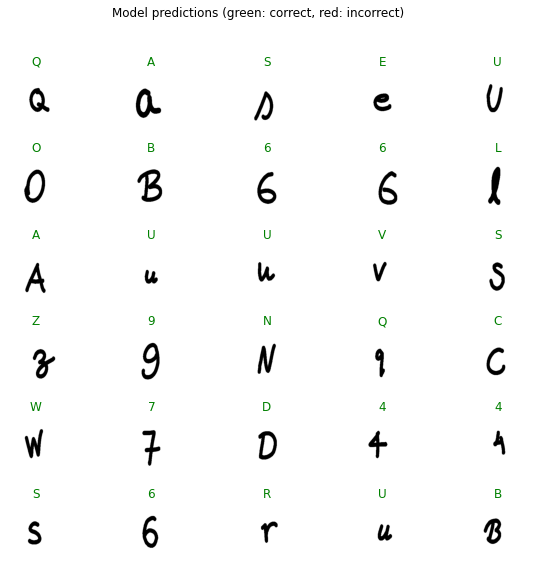

In [61]:
class_names = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])

predicted_batch = model.predict(image_batch_train)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
label_id = np.argmax(label_batch_train, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch_train[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [178]:
#im1=Image.open(imagepath1)
#im1=im1.resize((224,224),Image.ANTIALIAS)
#im1=np.array(im1)
#im1.save('im_b.jpg')

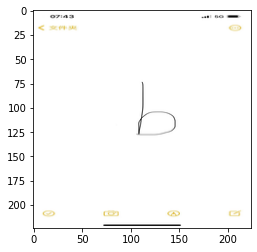

In [111]:
#plt.imshow(im1)

In [191]:
import tensorflow as tf
data_root='/content/gdrive/MyDrive/colab/class/test'
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR);
#datagen_kwargs = dict(rescale=1./255, validation_split=.20)
datagen_kwargs_train = dict(rescale=1./255)

train_datagen00 = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs_train)
train_generator00 = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=False,
    target_size=IMAGE_SHAPE)

/content/gdrive/MyDrive/colab/class/test
Found 8 images belonging to 2 classes.


In [192]:
predicted_batch00 = model.predict(train_generator00)
predicted_id00 = np.argmax(predicted_batch00, axis=-1)

In [193]:
class_names = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])

predicted_label = class_names[predicted_id00]


In [194]:
predicted_label

array(['D', 'B', 'O', 'O', 'G', 'E', 'G', 'G'], dtype='<U1')

In [195]:
predicted_id00

array([13, 11, 24, 24, 16, 14, 16, 16])

In [196]:
class_names

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], dtype='<U1')

In [134]:
class_names[24]

'O'